# Backtest for MACD vs HODL in cryptocurrency

I'm always curious about the MACD if it really works because it makes sense but too simple to be work. And another thing that I want to know is about  the cut loss technique that said if the price drop down to X%, sell it no matter what the indicators say.

These are things that I want to know in this back test.
1. Is MACD stretegy better than HODL?
2. Is daily MACD + weekly MACD (MACD Mixed stretegy) is better than daily MACD only?
3. Is cut loss really helpful? If so, how much should we set.

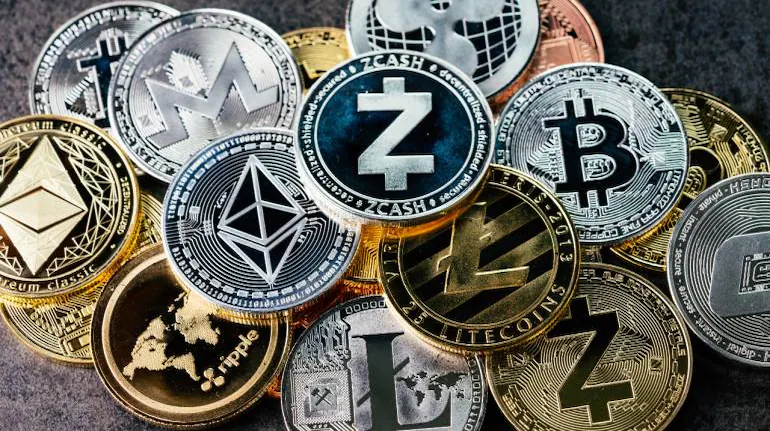

MACD=12-Period EMA − 26-Period EMA

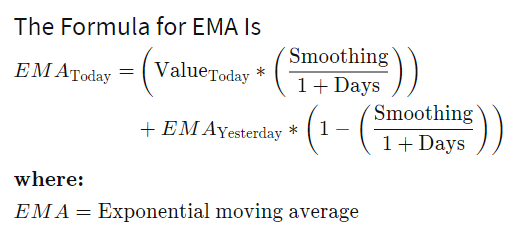

In [6]:
#!pip install pandas_datareader
import pandas_datareader as web
import datetime as dt
import pandas as pd
import yfinance as yf
from IPython.display import clear_output

start = dt.datetime(2016,1,1)
end = dt.datetime.now()

# Get historical price data from yahoo
def getData(coin,interval):
    return yf.download(coin,start,end,interval=interval)
#     return web.data.get_data_yahoo(coin,start,end,interval=interval)



In [2]:
#Calculate EMA
def calculate_ema(prices, days, smoothing=2):
    ema = [sum(prices[:days]) / days]
    for price in prices[days:]:
        ema.append((price * (smoothing / (1 + days))) + ema[-1] * (1 - (smoothing / (1 + days))))
    
    return_ema = []
    for i in range(days-1):
        return_ema.append(0)
    return_ema += ema
    return return_ema

#Calculate MACD
def get_MACD(coin):
    coin['ema12'] = calculate_ema(coin['Close'], 12) 
    coin['ema26'] = calculate_ema(coin['Close'], 26)
    coin['MACD'] = coin['ema12']-coin['ema26']
    coin.at[:25,'MACD']=0
    coin = coin[['High','Low','Close','MACD']]
    return coin

def get_Signal(coin,MACD):
    coin['Signal'] = calculate_ema(coin[MACD], 9)
    return coin
# Merge daily MACD and weekly MACD into one dataframe
def prep_MACD(coin):
    coin_d  = getData(coin, '1d')
    coin_w  = getData(coin, '1wk')

    coin_d = get_MACD(coin_d)
    coin_w = get_MACD(coin_w)
                      
    coin_d = get_Signal(coin_d,'MACD')
    coin_w = get_Signal(coin_w,'MACD')      
                      
    coin_final = coin_d.merge(coin_w[['MACD','Signal']], how = 'left', left_on = 'Date', right_on = 'Date', suffixes = ['_d','_w'])
    coin_final = coin_final.ffill(axis = 0)
    coin_final = coin_final.fillna(0)
    return coin_final


In [3]:
# Calculate return base on each stretegy and cut loss criteria (0.1 = cut loss after today's closing price is less than 10% of yesterday's lowest price)
def calculated_return(coin,stretegy,cutloss):
    coin['prev_low'] = ''
    pos = 'short'
    coin['position'] = ''
    cnt = 1
    pre_short_flg = 0
    low = 0
    net_list = []
    buy = 0
    sell = 0
    buy_list = []
    sell_list = []
    

######### MACD_Mixed ######################
# 
# Buy when weekly MACD is positive and daily MACD just turned from negative to positive
# Sell when daily MACD has negative value for 2 consecutive days and the price in the second day is lower than the lowest the first day (to avoid false signal)
# The price to BUY is the closing price of that day
# The price to SELL is [minimum of the lowest price in the first negative-daily-MACD day] and [highest price in the second negative-daily-MACD day]
#  
########################################
    if stretegy == 'MACD_Mixed':
        for index, row in coin.iterrows():
            if row['MACD_d'] > 0 and row['MACD_w']>0:
                if pos == 'short':
                    buy = row['Close']
                    pos = 'long'
                    buy_list.append(buy)
                pre_short_flg = 0
            elif row['Close']<low*(1-cutloss) and pos == 'long' and cutloss>0:
                pos = 'short'
                sell = min(low*(1-cutloss),row['High'])
                net = (sell-buy)/buy
                net_list.append(net)
                sell_list.append(sell)

            elif   row['MACD_d'] < 0 and row['MACD_w']>0 and pos == 'long' and pre_short_flg != 1:
                pos = 'long'
                pre_short_flg = 1

            elif   row['MACD_d'] < 0 and row['MACD_w']>0 and pos == 'long' and pre_short_flg == 1 and row['Low']<=low:
                pos = 'short'
                sell = min(low,row['High'])
                net = (sell-buy)/buy
                net_list.append(net)
                sell_list.append(sell)

            elif   row['MACD_d'] < 0 and row['MACD_w']>0 and pos == 'long' and pre_short_flg == 1 and row['Low']>low:
                pos = 'long'
                pre_short_flg = 1
            elif   (row['MACD_d'] < 0 and row['MACD_w']<0):
                pos = 'short'
            else:
                pos = 'short'

            coin.at[cnt-1:cnt,'position'] = pos
            coin.at[cnt-1:cnt,'prev_low'] = low
            low = row['Low']
            cnt += 1
        
        init = 1

        for i in range(len(net_list)):
            init = init*(1+net_list[i])
        return init
    
######### MACD_Daily ######################
# 
# Buy when daily MACD just turned from negative to positive
# Sell when daily MACD just turned from negative to positive or the cut loss condition is met (closing price is lower than the lowest of yesterday for X%)
# The price to BUY is the closing price of that day
# The price to SELL is the closing price of that day
# 
########################################

    elif stretegy == 'MACD_Daily':
        for index, row in coin.iterrows():
            if row['MACD_d'] > 0:
                if pos == 'short':
                    buy = row['Close']
                    pos = 'long'
                    buy_list.append(buy)
                pre_short_flg = 0

            elif row['Close']<low*(1-cutloss) and pos == 'long' and cutloss>0:
                pos = 'short'
                sell = min(low,row['High'])
                net = (sell-buy)/buy
                net_list.append(net)
                sell_list.append(sell)
            elif   row['MACD_d'] < 0 and pos == 'long' and pre_short_flg != 1 :
                pos = 'long'
                pre_short_flg = 1

            elif   row['MACD_d'] < 0 and pos == 'long' and pre_short_flg == 1 and row['Low']<=low:
                pos = 'short'
                sell = min(low,row['High'])
                net = (sell-buy)/buy
                net_list.append(net)
                sell_list.append(sell)

            elif   row['MACD_d'] < 0  and pos == 'long' and pre_short_flg == 1 and row['Low']>low:
                pos = 'long'
                pre_short_flg = 1
            elif   (row['MACD_d'] < 0):
                pos = 'short'
            else:
                pos = 'short'

            coin.at[cnt-1:cnt,'position'] = pos
            coin.at[cnt-1:cnt,'prev_low'] = low
            low = row['Low']
            cnt += 1
        
        init = 1

        for i in range(len(net_list)):
            init = init*(1+net_list[i])
        return init
    

######### MACD_Signal_Mixed ######################
# 
# Buy when weekly MACD > Signal and daily MACD just went over signal value
# Sell when daily MACD < Signal for 2 consecutive days and the price in the second day is lower than the lowest the first day (to avoid false signal)
# The price to BUY is the closing price of that day
# The price to SELL is [minimum of the lowest price in the first negative-daily-MACD day] and [highest price in the second negative-daily-MACD day]
# 
########################################


    if stretegy == 'MACD_Signal_Mixed':
        for index, row in coin.iterrows():
            if row['MACD_d'] > row['Signal_d'] and row['MACD_w']>row['Signal_w']:
                if pos == 'short':
                    buy = row['Close']
                    pos = 'long'
                    buy_list.append(buy)
                pre_short_flg = 0
            elif row['Close']<low*(1-cutloss) and pos == 'long' and cutloss>0:
                pos = 'short'
                sell = min(low*(1-cutloss),row['High'])
                net = (sell-buy)/buy
                net_list.append(net)
                sell_list.append(sell)

            elif   row['MACD_d'] < row['Signal_d'] and row['MACD_w']>row['Signal_w'] and pos == 'long' and pre_short_flg != 1:
                pos = 'long'
                pre_short_flg = 1

            elif   row['MACD_d'] < row['Signal_d'] and row['MACD_w']>row['Signal_w'] and pos == 'long' and pre_short_flg == 1 and row['Low']<=low:
                pos = 'short'
                sell = min(low,row['High'])
                net = (sell-buy)/buy
                net_list.append(net)
                sell_list.append(sell)

            elif   row['MACD_d'] < row['Signal_d'] and row['MACD_w']>row['Signal_w'] and pos == 'long' and pre_short_flg == 1 and row['Low']>low:
                pos = 'long'
                pre_short_flg = 1
            elif   (row['MACD_d'] < row['Signal_d'] and row['MACD_w']<row['Signal_w']):
                pos = 'short'
            else:
                pos = 'short'

            coin.at[cnt-1:cnt,'position'] = pos
            coin.at[cnt-1:cnt,'prev_low'] = low
            low = row['Low']
            cnt += 1
        
        init = 1

        for i in range(len(net_list)):
            init = init*(1+net_list[i])
        return init

    
######### MACD_Daily ######################
# 
# Buy when daily MACD just went over signal value
# Sell when daily MACD just went underneath Signal value or the cut loss condition is met (closing price is lower than the lowest of yesterday for X%)
# The price to BUY is the closing price of that day
# The price to SELL is the closing price of that day
# 
########################################

    elif stretegy == 'MACD_Signal_Daily':
 
        for index, row in coin.iterrows():
            if row['MACD_d'] > row['Signal_d']:
                if pos == 'short':
                    buy = row['Close']
                    pos = 'long'
                    buy_list.append(buy)
                pre_short_flg = 0

            elif row['Close']<low*(1-cutloss) and pos == 'long' and cutloss>0:
                pos = 'short'
                sell = min(low,row['High'])
                net = (sell-buy)/buy
                net_list.append(net)
                sell_list.append(sell)

            elif   row['MACD_d'] < row['Signal_d'] and pos == 'long' and pre_short_flg != 1 :
                pos = 'long'
                pre_short_flg = 1
    

            elif   row['MACD_d'] < row['Signal_d'] and pos == 'long' and pre_short_flg == 1 and row['Low']<=low:
                pos = 'short'
                sell = min(low,row['High'])
                net = (sell-buy)/buy
                net_list.append(net)
                sell_list.append(sell)
      

            elif   row['MACD_d'] < row['Signal_d'] and pos == 'long' and pre_short_flg == 1 and row['Low']>low:
                pos = 'long'
                pre_short_flg = 1
              
            elif   (row['MACD_d'] < row['Signal_d'] ):
                pos = 'short'
                
            else:
                pos = 'short'

            coin.at[cnt-1:cnt,'position'] = pos
            coin.at[cnt-1:cnt,'prev_low'] = low
            low = row['Low']
            cnt += 1
        
        init = 1

        for i in range(len(net_list)):
            init = init*(1+net_list[i])
        return init

######### MACD_HODL ######################
# 
# Buy after 26 days has passed (to make it more fair since the MACD stretegy require 26 days to get MACD value)
# Sell when daily MACD just turned from negative to positive or the cut loss condition is met (closing price is lower than the lowest of yesterday for X%)
# The price to BUY is the closing price of that day
# The price to SELL is the closing price of that day
# 
########################################    

    elif stretegy == 'HODL':
        buy = coin['Close'][0]
        sell = coin.tail(1)['Close'][0]
        return sell/buy
    







In [9]:
#Setting blank data frame
header = {'start_date' : [], 'coin' : [], 'stretegy' : [], 'cut_loss' : [], 'end_result' :[]}
result_df = pd.DataFrame(header)

# Start date of the back test
start_list = [ '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01']

# Crypto list that we are going to test
crypto_list = ['BTC-USD','ETH-USD','BNB-USD','XRP-USD','ADA-USD'
          , 'LINK-USD', 'DOT1-USD', 'LUNA1-USD','VET-USD']

stretegy_list = ['HODL','MACD_Mixed','MACD_Daily','MACD_Signal_Mixed','MACD_Signal_Daily']

# No cut loss vs cut loss at 10%
cut_loss_list = [0, 0.1]

for start_date in start_list:
    for coin in crypto_list:
        for stretegy in stretegy_list:
            for cut_loss in cut_loss_list:
                if stretegy == 'HODL' and cut_loss >0:
                    break
                coin_final = prep_MACD(coin)
                clear_output()
                coin_final = coin_final[start_date:]
                
                result = str(calculated_return(coin_final,stretegy,cut_loss))
                new_row = {'start_date': start_date, 'coin': coin, 'stretegy':stretegy ,'cut_loss':cut_loss, 'end_result':result}
#                 print(new_row)
                
                result_df = result_df.append(new_row,ignore_index=True)

In [12]:
result_df.to_excel('MACD Backtest.xlsx')

# Key takeaway from the result

To make visualization easier, I built the dashboard to view the result.

https://public.tableau.com/app/profile/wongsatorn/viz/MACDvsHODLincryptocurrencybacktest/BacktestResult


Below are keys takeaway I found:
1. Simple daily MACD > 0 win most of the scenario
2. Include cut loss into stretegy "always" improve the result. In this backtest, cut loss will be activated when toay's closing price is lower than the lowest of yesterday by 10%
3. MACD-Signal do well in the coin that price didn't grow well (XRP in this case)
4. Mixed stretegy (daily + weekly) lose to daily stretegy in most case due to missed-opportunity.